# Results Generator



Tables:
- Table 1: MCAR MSE
- Table 2: MCAR W2
- Table 3: MNAR MSE
- Table 4: MNAR W2

In [2]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
# Configuration
RESULTS_DIR = Path('results')

# Datasets sorted from small N to large N
DATASETS = ['cnnpred', 'pems08', 'pm25', 'gassensor', 'gait', 'pems04', 'cmapss', 'airquality', 'har', 'physionet']

# Missing ratios to average over
MISSING_RATIOS = [10, 50, 90]

# Methods organized by category
BASELINES = ['mean', 'mf']
BENCHMARKS = ['csdi', 'mdot', 'psw', 'brits', 'notmiwae']
OURS = ['drio_brits']

# Display names for methods (for cleaner table output)
METHOD_DISPLAY_NAMES = {
    'mean': 'Mean',
    'mf': 'MF',
    'csdi': 'CSDI',
    'mdot': 'MDOT',
    'psw': 'PSW',
    'brits': 'BRITS',
    'notmiwae': 'nMW',
    'drio_brits': 'DRIO',
}

# All methods in order for table
ALL_METHODS = BASELINES + BENCHMARKS + OURS

In [4]:
def load_results(dataset, missing_type, missing_ratio, method):
    """
    Load evaluation results from JSON file.
    
    Returns dict with 'mse' and 'w2' keys, or None if file doesn't exist.
    """
    # Construct path
    folder_name = f"{dataset}_{missing_type}_{missing_ratio}pct_split70-10-20_seed42"
    json_path = RESULTS_DIR / dataset / folder_name / method / 'evaluation_results.json'
    
    if not json_path.exists():
        return None
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Get test metrics
        test_data = data.get('test', {})
        return {
            'mse': test_data.get('mse'),
            'w2': test_data.get('w2_global')
        }
    except Exception as e:
        print(f"Error loading {json_path}: {e}")
        return None

In [5]:
def compute_average_metric(dataset, missing_type, method, metric='mse'):
    """
    Compute average metric across all missing ratios for a given dataset/method.
    
    Returns float or np.nan if data unavailable.
    """
    values = []
    for ratio in MISSING_RATIOS:
        result = load_results(dataset, missing_type, ratio, method)
        if result and result.get(metric) is not None:
            values.append(result[metric])
    
    if values:
        return np.mean(values)
    return np.nan

In [6]:
def build_results_table(missing_type, metric='mse'):
    """
    Build a pandas DataFrame with results.
    
    Rows: methods
    Columns: datasets
    Values: average metric across missing ratios
    """
    data = {}
    for method in ALL_METHODS:
        row = {}
        for dataset in DATASETS:
            row[dataset] = compute_average_metric(dataset, missing_type, method, metric)
        data[method] = row
    
    df = pd.DataFrame(data).T
    df.index.name = 'Method'
    return df

In [7]:
def format_value(val, is_top3=False):
    """
    Format a value for LaTeX output with 2 decimal points.
    """
    if pd.isna(val):
        return '--'
    
    formatted = f"{val:.2f}"
    
    if is_top3:
        return f"\\textbf{{{formatted}}}"
    return formatted

In [8]:
def get_top3_indices(column):
    """
    Get indices of the top 3 smallest values in a column.
    """
    valid_values = column.dropna()
    if len(valid_values) < 3:
        return valid_values.nsmallest(len(valid_values)).index.tolist()
    return valid_values.nsmallest(3).index.tolist()

In [9]:
def generate_latex_table(df, caption, label, metric_name='MSE'):
    """
    Generate LaTeX table code for submission.
    
    Features:
    - Smaller font (\\small or \\footnotesize)
    - Bold top 3 per column
    - Grouped rows: Baselines, Benchmarks, Ours
    """
    n_cols = len(DATASETS)
    
    # Get top 3 indices per dataset
    top3_per_dataset = {ds: get_top3_indices(df[ds]) for ds in DATASETS}
    
    # Build LaTeX
    lines = []
    lines.append(r"\begin{table}[t]")
    lines.append(r"\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append(r"\footnotesize")
    lines.append(r"\resizebox{\columnwidth}{!}{%")
    
    # Column format: l for method name, c for each dataset
    col_fmt = 'l' + 'c' * n_cols
    lines.append(f"\\begin{{tabular}}{{{col_fmt}}}")
    lines.append(r"\toprule")
    
    # Header row
    header = "Method & " + " & ".join([ds.upper() for ds in DATASETS]) + r" \\"
    lines.append(header)
    lines.append(r"\midrule")
    
    def add_method_rows(methods, group_name=None):
        """Add rows for a group of methods."""
        row_lines = []
        if group_name:
            row_lines.append(f"\\multicolumn{{{n_cols + 1}}}{{l}}{{\\textit{{{group_name}}}}} \\\\")
        
        for method in methods:
            display_name = METHOD_DISPLAY_NAMES.get(method, method)
            values = []
            for ds in DATASETS:
                val = df.loc[method, ds]
                is_top3 = method in top3_per_dataset[ds]
                values.append(format_value(val, is_top3))
            
            row = display_name + " & " + " & ".join(values) + r" \\"
            row_lines.append(row)
        return row_lines
    
    # Add grouped rows
    lines.extend(add_method_rows(BASELINES, "Baselines"))
    lines.append(r"\addlinespace[2pt]")
    lines.extend(add_method_rows(BENCHMARKS, "Benchmarks"))
    lines.append(r"\addlinespace[2pt]")
    lines.extend(add_method_rows(OURS, "Ours"))
    
    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}}")
    lines.append(r"\end{table}")
    
    return "\n".join(lines)


def generate_latex_table_transposed(df, caption, label, metric_name='MSE'):
    """
    Generate transposed LaTeX table code for submission.
    
    Rows: datasets
    Columns: methods (grouped by category)
    
    Features:
    - Smaller font
    - Bold top 3 per row (dataset)
    - Grouped columns: Baselines, Benchmarks, Ours
    """
    n_methods = len(ALL_METHODS)
    n_baselines = len(BASELINES)
    n_benchmarks = len(BENCHMARKS)
    n_ours = len(OURS)
    
    # Get top 3 methods per dataset (row)
    df_T = df.T  # Transpose: rows are datasets, columns are methods
    top3_per_dataset = {ds: get_top3_indices(df_T.loc[ds]) for ds in DATASETS}
    
    # Build LaTeX
    lines = []
    lines.append(r"\begin{table}[t]")
    lines.append(r"\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append(r"\footnotesize")
    lines.append(r"\resizebox{\columnwidth}{!}{%")
    
    # Column format: l for dataset name, c for each method
    col_fmt = 'l' + 'c' * n_methods
    lines.append(f"\\begin{{tabular}}{{{col_fmt}}}")
    lines.append(r"\toprule")
    
    # Category header row
    category_header = f" & \\multicolumn{{{n_baselines}}}{{c}}{{\\textit{{Baselines}}}} & \\multicolumn{{{n_benchmarks}}}{{c}}{{\\textit{{Benchmarks}}}} & \\multicolumn{{{n_ours}}}{{c}}{{\\textit{{Ours}}}} \\\\"
    lines.append(category_header)
    
    # Add cmidrule for visual separation
    baseline_end = 1 + n_baselines
    benchmark_end = baseline_end + n_benchmarks
    ours_end = benchmark_end + n_ours
    lines.append(f"\\cmidrule(lr){{2-{baseline_end}}} \\cmidrule(lr){{{baseline_end+1}-{benchmark_end}}} \\cmidrule(lr){{{benchmark_end+1}-{ours_end}}}")
    
    # Method names header row
    method_names = [METHOD_DISPLAY_NAMES.get(m, m) for m in ALL_METHODS]
    header = "Dataset & " + " & ".join(method_names) + r" \\"
    lines.append(header)
    lines.append(r"\midrule")
    
    # Data rows (one per dataset)
    for ds in DATASETS:
        values = []
        for method in ALL_METHODS:
            val = df.loc[method, ds]
            is_top3 = method in top3_per_dataset[ds]
            values.append(format_value(val, is_top3))
        
        row = ds.upper() + " & " + " & ".join(values) + r" \\"
        lines.append(row)
    
    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}}")
    lines.append(r"\end{table}")
    
    return "\n".join(lines)

## Build and Display Tables

In [10]:
# Table 1: MCAR MSE
print("=" * 80)
print("TABLE 1: MCAR MSE")
print("=" * 80)

df_mcar_mse = build_results_table('mcar', 'mse')
print("\nDataFrame:")
print(df_mcar_mse.round(4))

latex_mcar_mse = generate_latex_table(
    df_mcar_mse,
    caption="Imputation performance (MSE) under MCAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mcar_mse"
)
print("\n" + "=" * 40 + " LaTeX Code " + "=" * 40)
print(latex_mcar_mse)

TABLE 1: MCAR MSE

DataFrame:
            cnnpred   pems08    pm25  gassensor    gait  pems04  cmapss  \
Method                                                                    
mean         1.1096   1.2738  1.5300     1.0875  0.2980  0.9523  1.0789   
mf           1.4531   2.4250  1.9989     0.4421  0.8215  1.7230  1.0826   
csdi         0.8015  14.1075  1.0978     0.5559  0.0419  3.6573  0.0806   
mdot         0.8873   0.6362  1.1751     0.3162  0.1466  0.4233  0.6879   
psw          1.0581   0.2775  0.2222     0.0112  0.2226  0.4012  0.8711   
brits        0.5335   0.4159  0.9329     0.0579  0.1460  0.4336  0.2889   
notmiwae     2.5777   3.3109  3.0971     2.0671  2.7951  3.1305  0.5941   
drio_brits   0.5233   0.4485  0.5952     0.0741  0.1373  0.4067  0.2189   

            airquality     har  physionet  
Method                                     
mean            0.7983  1.0125     1.0257  
mf              1.7666  1.6803     1.9607  
csdi            0.1550  0.2116     0.4805  

In [11]:
# Table 2: MCAR W2
print("=" * 80)
print("TABLE 2: MCAR W2")
print("=" * 80)

df_mcar_w2 = build_results_table('mcar', 'w2')
print("\nDataFrame:")
print(df_mcar_w2.round(4))

latex_mcar_w2 = generate_latex_table(
    df_mcar_w2,
    caption="Distributional accuracy (Wasserstein-2) under MCAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mcar_w2"
)
print("\n" + "=" * 40 + " LaTeX Code " + "=" * 40)
print(latex_mcar_w2)

TABLE 2: MCAR W2

DataFrame:
            cnnpred  pems08    pm25  gassensor    gait  pems04  cmapss  \
Method                                                                   
mean         0.2308  0.2790  0.3341     0.3406  0.0699  0.2423  0.3737   
mf           0.1371  0.4570  0.3146     0.1273  0.1441  0.3283  0.1879   
csdi         0.3121  1.6203  0.3030     0.3279  0.0499  0.4983  0.0633   
mdot         0.1891  0.1956  0.2980     0.1974  0.0499  0.1678  0.2098   
psw          0.1004  0.0464  0.1145     0.0078  0.0872  0.0563  0.1556   
brits        0.2472  0.2661  0.3141     0.0568  0.1025  0.1909  0.1930   
notmiwae     0.8198  0.9905  0.8517     0.7803  0.8942  0.9636  0.3574   
drio_brits   0.1807  0.2425  0.2811     0.0637  0.0853  0.1659  0.1827   

            airquality     har  physionet  
Method                                     
mean            0.2052  0.3953     0.3597  
mf              0.3317  0.1065     0.1989  
csdi            0.1137  0.0993     0.1776  
mdot      

In [12]:
# Table 3: MNAR MSE
print("=" * 80)
print("TABLE 3: MNAR MSE")
print("=" * 80)

df_mnar_mse = build_results_table('mnar', 'mse')
print("\nDataFrame:")
print(df_mnar_mse.round(4))

latex_mnar_mse = generate_latex_table(
    df_mnar_mse,
    caption="Imputation performance (MSE) under MNAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mnar_mse"
)
print("\n" + "=" * 40 + " LaTeX Code " + "=" * 40)
print(latex_mnar_mse)

TABLE 3: MNAR MSE

DataFrame:
            cnnpred   pems08    pm25  gassensor    gait  pems04  cmapss  \
Method                                                                    
mean         1.3505   1.2028  1.4888     1.4017  0.3332  0.8111  1.1549   
mf           1.6695   2.3680  1.7630     0.5654  0.8509  1.5544  1.1636   
csdi         1.3145  49.7559  1.0673     0.6408  0.0660  0.2380  0.1391   
mdot         0.9790   0.6525  1.1671     0.4114  0.1800  0.4126  0.7894   
psw          1.3132   0.3757  0.4222     0.0160  0.3012  0.3776  0.9250   
brits        0.7643   0.5436  0.9128     0.0847  0.2062  0.4310  0.3578   
notmiwae     2.2359   2.8276  2.9992     1.2801  2.4691  2.6840  0.6484   
drio_brits   0.7360   0.5230  0.6334     0.0879  0.1542  0.4088  0.2727   

            airquality     har  physionet  
Method                                     
mean            0.9228  1.2336     1.3511  
mf              1.7307  1.8953     2.2579  
csdi            0.2146  0.2867     0.7497  

In [13]:
# Table 4: MNAR W2
print("=" * 80)
print("TABLE 4: MNAR W2")
print("=" * 80)

df_mnar_w2 = build_results_table('mnar', 'w2')
print("\nDataFrame:")
print(df_mnar_w2.round(4))

latex_mnar_w2 = generate_latex_table(
    df_mnar_w2,
    caption="Distributional accuracy (Wasserstein-2) under MNAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mnar_w2"
)
print("\n" + "=" * 40 + " LaTeX Code " + "=" * 40)
print(latex_mnar_w2)

TABLE 4: MNAR W2

DataFrame:
            cnnpred  pems08    pm25  gassensor    gait  pems04  cmapss  \
Method                                                                   
mean         0.3331  0.3137  0.4570     0.4351  0.1167  0.2781  0.4010   
mf           0.2043  0.4579  0.3631     0.1456  0.1577  0.3439  0.2183   
csdi         0.4013  2.5301  0.4118     0.3519  0.0822  0.1834  0.1042   
mdot         0.2891  0.2501  0.4191     0.2790  0.0948  0.2248  0.2798   
psw          0.1923  0.0933  0.2277     0.0172  0.1517  0.0972  0.2133   
brits        0.3562  0.3165  0.4357     0.0996  0.1666  0.2505  0.2442   
notmiwae     0.7083  0.8932  0.8334     0.5743  0.7972  0.8871  0.3919   
drio_brits   0.3169  0.2902  0.3867     0.0602  0.1137  0.2281  0.2139   

            airquality     har  physionet  
Method                                     
mean            0.3046  0.4579     0.4504  
mf              0.2804  0.1284     0.2313  
csdi            0.1633  0.1687     0.2572  
mdot      

## Summary: All LaTeX Tables

In [14]:
# Print all LaTeX tables together for easy copy-paste
print("\n" + "=" * 80)
print("ALL LATEX TABLES FOR SUBMISSION")
print("=" * 80)

print("\n% " + "-" * 60)
print("% Table 1: MCAR MSE")
print("% " + "-" * 60)
print(latex_mcar_mse)

print("\n% " + "-" * 60)
print("% Table 2: MCAR W2")
print("% " + "-" * 60)
print(latex_mcar_w2)

print("\n% " + "-" * 60)
print("% Table 3: MNAR MSE")
print("% " + "-" * 60)
print(latex_mnar_mse)

print("\n% " + "-" * 60)
print("% Table 4: MNAR W2")
print("% " + "-" * 60)
print(latex_mnar_w2)

# Generate and print transposed tables
print("\n" + "=" * 80)
print("TRANSPOSED LATEX TABLES (Rows=Datasets, Cols=Methods)")
print("=" * 80)

latex_mcar_mse_T = generate_latex_table_transposed(
    df_mcar_mse,
    caption="Imputation performance (MSE) under MCAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mcar_mse_transposed"
)
print("\n% " + "-" * 60)
print("% Table 1T: MCAR MSE (Transposed)")
print("% " + "-" * 60)
print(latex_mcar_mse_T)

latex_mcar_w2_T = generate_latex_table_transposed(
    df_mcar_w2,
    caption="Distributional accuracy (Wasserstein-2) under MCAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mcar_w2_transposed"
)
print("\n% " + "-" * 60)
print("% Table 2T: MCAR W2 (Transposed)")
print("% " + "-" * 60)
print(latex_mcar_w2_T)

latex_mnar_mse_T = generate_latex_table_transposed(
    df_mnar_mse,
    caption="Imputation performance (MSE) under MNAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mnar_mse_transposed"
)
print("\n% " + "-" * 60)
print("% Table 3T: MNAR MSE (Transposed)")
print("% " + "-" * 60)
print(latex_mnar_mse_T)

latex_mnar_w2_T = generate_latex_table_transposed(
    df_mnar_w2,
    caption="Distributional accuracy (Wasserstein-2) under MNAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset.",
    label="tab:mnar_w2_transposed"
)
print("\n% " + "-" * 60)
print("% Table 4T: MNAR W2 (Transposed)")
print("% " + "-" * 60)
print(latex_mnar_w2_T)


ALL LATEX TABLES FOR SUBMISSION

% ------------------------------------------------------------
% Table 1: MCAR MSE
% ------------------------------------------------------------
\begin{table}[t]
\centering
\caption{Imputation performance (MSE) under MCAR missing mechanism. Values are averaged across 10\%, 50\%, and 90\% missing ratios. Bold indicates top 3 per dataset.}
\label{tab:mcar_mse}
\footnotesize
\resizebox{\columnwidth}{!}{%
\begin{tabular}{lcccccccccc}
\toprule
Method & CNNPRED & PEMS08 & PM25 & GASSENSOR & GAIT & PEMS04 & CMAPSS & AIRQUALITY & HAR & PHYSIONET \\
\midrule
\multicolumn{11}{l}{\textit{Baselines}} \\
Mean & 1.11 & 1.27 & 1.53 & 1.09 & 0.30 & 0.95 & 1.08 & 0.80 & 1.01 & 1.03 \\
MF & 1.45 & 2.42 & 2.00 & 0.44 & 0.82 & 1.72 & 1.08 & 1.77 & 1.68 & 1.96 \\
\addlinespace[2pt]
\multicolumn{11}{l}{\textit{Benchmarks}} \\
CSDI & \textbf{0.80} & 14.11 & 1.10 & 0.56 & \textbf{0.04} & 3.66 & \textbf{0.08} & \textbf{0.15} & \textbf{0.21} & \textbf{0.48} \\
MDOT & 0.89 & 0.

## Check Data Availability

In [15]:
# Check which method/dataset combinations have missing data
print("Data Availability Check")
print("=" * 80)

for missing_type in ['mcar', 'mnar']:
    print(f"\n{missing_type.upper()}:")
    for method in ALL_METHODS:
        missing_ds = []
        for dataset in DATASETS:
            for ratio in MISSING_RATIOS:
                result = load_results(dataset, missing_type, ratio, method)
                if result is None:
                    missing_ds.append(f"{dataset}_{ratio}%")
        if missing_ds:
            print(f"  {method}: MISSING - {missing_ds}")

Data Availability Check

MCAR:

MNAR:


## Combined Tables (MSE + W2 stacked)

Generate combined tables with MSE on top, W2 on bottom, separated by double hline.

In [16]:
def generate_combined_latex_table(df_mse, df_w2, missing_type, caption, label):
    """
    Generate combined LaTeX table with MSE on top, W2 on bottom.
    
    Rows: datasets (repeated for each metric)
    Columns: methods (grouped by category)
    Separated by double hline between MSE and W2 sections
    """
    n_methods = len(ALL_METHODS)
    n_baselines = len(BASELINES)
    n_benchmarks = len(BENCHMARKS)
    n_ours = len(OURS)
    
    # Get top 3 methods per dataset for each metric
    df_mse_T = df_mse.T  # Transpose: rows are datasets, columns are methods
    df_w2_T = df_w2.T
    top3_mse = {ds: get_top3_indices(df_mse_T.loc[ds]) for ds in DATASETS}
    top3_w2 = {ds: get_top3_indices(df_w2_T.loc[ds]) for ds in DATASETS}
    
    # Dataset display names
    dataset_display = {
        'cnnpred': 'CNNpred',
        'pems08': 'PEMS08',
        'pm25': 'PM2.5',
        'gassensor': 'GasSensor',
        'gait': 'Gait',
        'pems04': 'PEMS04',
        'cmapss': 'CMAPSS',
        'airquality': 'AirQuality',
        'har': 'HAR',
        'physionet': 'PhysioNet',
    }
    
    # Build LaTeX
    lines = []
    lines.append(r"\begin{table}[t]")
    lines.append(r"\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append(r"\footnotesize")
    lines.append(r"\setlength{\tabcolsep}{1.5pt}")
    
    # Column format: l for dataset name, c for each method
    col_fmt = 'l' + 'c' * n_methods
    lines.append(f"\\begin{{tabular}}{{{col_fmt}}}")
    lines.append(r"\toprule")
    
    # Category header row
    category_header = f" & \\multicolumn{{{n_baselines}}}{{c}}{{\\textit{{Baselines}}}} & \\multicolumn{{{n_benchmarks}}}{{c}}{{\\textit{{Benchmarks}}}} & \\multicolumn{{{n_ours}}}{{c}}{{\\textit{{Ours}}}} \\\\"
    lines.append(category_header)
    
    # Add cmidrule for visual separation
    baseline_end = 1 + n_baselines
    benchmark_end = baseline_end + n_benchmarks
    ours_end = benchmark_end + n_ours
    lines.append(f"\\cmidrule(lr){{2-{baseline_end}}} \\cmidrule(lr){{{baseline_end+1}-{benchmark_end}}} \\cmidrule(lr){{{benchmark_end+1}-{ours_end}}}")
    
    # Method names header row
    method_names = [METHOD_DISPLAY_NAMES.get(m, m) for m in ALL_METHODS]
    header = "Dataset & " + " & ".join(method_names) + r" \\"
    lines.append(header)
    lines.append(r"\midrule")
    
    # MSE section header
    lines.append(f"\\multicolumn{{{n_methods + 1}}}{{l}}{{\\textit{{MSE (Imputation Accuracy)}}}} \\\\")
    
    # MSE data rows
    for ds in DATASETS:
        values = []
        for method in ALL_METHODS:
            val = df_mse.loc[method, ds]
            is_top3 = method in top3_mse[ds]
            values.append(format_value(val, is_top3))
        
        row = dataset_display.get(ds, ds.upper()) + " & " + " & ".join(values) + r" \\"
        lines.append(row)
    
    # Double hline separator
    lines.append(r"\hline\hline")
    
    # W2 section header
    lines.append(f"\\multicolumn{{{n_methods + 1}}}{{l}}{{\\textit{{W2 (Distributional Alignment)}}}} \\\\")
    
    # W2 data rows
    for ds in DATASETS:
        values = []
        for method in ALL_METHODS:
            val = df_w2.loc[method, ds]
            is_top3 = method in top3_w2[ds]
            values.append(format_value(val, is_top3))
        
        row = dataset_display.get(ds, ds.upper()) + " & " + " & ".join(values) + r" \\"
        lines.append(row)
    
    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")
    lines.append(r"\end{table}")
    
    return "\n".join(lines)

In [17]:
# Generate Combined Tables (MCAR and MNAR)
print("=" * 80)
print("COMBINED TABLES (MSE + W2 STACKED)")
print("=" * 80)

# MCAR Combined Table
latex_mcar_combined = generate_combined_latex_table(
    df_mcar_mse, df_mcar_w2, 'mcar',
    caption="Imputation results under MCAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset. DRIO is paired with BRITS backbone.",
    label="tab:mcar_combined"
)
print("\n% " + "-" * 60)
print("% Combined Table: MCAR (MSE + W2)")
print("% " + "-" * 60)
print(latex_mcar_combined)

# MNAR Combined Table
latex_mnar_combined = generate_combined_latex_table(
    df_mnar_mse, df_mnar_w2, 'mnar',
    caption="Imputation results under MNAR missing mechanism. Values are averaged across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset. DRIO is paired with BRITS backbone.",
    label="tab:mnar_combined"
)
print("\n% " + "-" * 60)
print("% Combined Table: MNAR (MSE + W2)")
print("% " + "-" * 60)
print(latex_mnar_combined)

COMBINED TABLES (MSE + W2 STACKED)

% ------------------------------------------------------------
% Combined Table: MCAR (MSE + W2)
% ------------------------------------------------------------
\begin{table}[t]
\centering
\caption{Imputation results under MCAR missing mechanism. Values are averaged across 10\%, 50\%, and 90\% missing ratios. Bold indicates top 3 per dataset. DRIO is paired with BRITS backbone.}
\label{tab:mcar_combined}
\footnotesize
\setlength{\tabcolsep}{1.5pt}
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{2}{c}{\textit{Baselines}} & \multicolumn{5}{c}{\textit{Benchmarks}} & \multicolumn{1}{c}{\textit{Ours}} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-8} \cmidrule(lr){9-9}
Dataset & Mean & MF & CSDI & MDOT & PSW & BRITS & nMW & DRIO \\
\midrule
\multicolumn{9}{l}{\textit{MSE (Imputation Accuracy)}} \\
CNNpred & 1.11 & 1.45 & \textbf{0.80} & 0.89 & 1.06 & \textbf{0.53} & 2.58 & \textbf{0.52} \\
PEMS08 & 1.27 & 2.42 & 14.11 & 0.64 & \textbf{0.28} & \textbf{0.42} & 3.

## Combined Tables with Standard Deviation (MSE + W2 stacked)

Generate combined tables with MSE on top, W2 on bottom, with values showing mean(std).

In [18]:
def compute_metric_with_std(dataset, missing_type, method, metric='mse'):
    """
    Compute mean and std of metric across all missing ratios for a given dataset/method.

    Returns (mean, std) or (np.nan, np.nan) if data unavailable.
    """
    values = []
    for ratio in MISSING_RATIOS:
        result = load_results(dataset, missing_type, ratio, method)
        if result and result.get(metric) is not None:
            values.append(result[metric])

    if values:
        return np.mean(values), np.std(values, ddof=1) if len(values) > 1 else 0.0
    return np.nan, np.nan


def build_results_table_with_std(missing_type, metric='mse'):
    """
    Build pandas DataFrames with mean and std results.

    Rows: methods
    Columns: datasets
    Returns: (df_mean, df_std)
    """
    data_mean = {}
    data_std = {}
    for method in ALL_METHODS:
        row_mean = {}
        row_std = {}
        for dataset in DATASETS:
            mean, std = compute_metric_with_std(dataset, missing_type, method, metric)
            row_mean[dataset] = mean
            row_std[dataset] = std
        data_mean[method] = row_mean
        data_std[method] = row_std

    df_mean = pd.DataFrame(data_mean).T
    df_std = pd.DataFrame(data_std).T
    df_mean.index_name = 'Method'
    df_std.index_name = 'Method'
    return df_mean, df_std


def format_value_with_std(mean, std, is_top3=False):
    """
    Format a value as mean(std) for LaTeX output with 2 decimal points.
    """
    if pd.isna(mean):
        return '--'

    if pd.isna(std) or std == 0:
        formatted = f"{mean:.2f}"
    else:
        formatted = f"{mean:.2f}({std:.2f})"

    if is_top3:
        return f"\\textbf{{{formatted}}}"
    return formatted


def generate_combined_latex_table_with_std(df_mse_mean, df_mse_std, df_w2_mean, df_w2_std, missing_type, caption, label):
    """
    Generate combined LaTeX table with MSE on top, W2 on bottom, including std.

    Rows: datasets (repeated for each metric)
    Columns: methods (grouped by category)
    Values: mean(std) format
    Separated by double hline between MSE and W2 sections
    """
    n_methods = len(ALL_METHODS)
    n_baselines = len(BASELINES)
    n_benchmarks = len(BENCHMARKS)
    n_ours = len(OURS)

    # Get top 3 methods per dataset for each metric (based on mean)
    df_mse_T = df_mse_mean.T  # Transpose: rows are datasets, columns are methods
    df_w2_T = df_w2_mean.T
    top3_mse = {ds: get_top3_indices(df_mse_T.loc[ds]) for ds in DATASETS}
    top3_w2 = {ds: get_top3_indices(df_w2_T.loc[ds]) for ds in DATASETS}

    # Dataset display names
    dataset_display = {
        'cnnpred': 'CNNpred',
        'pems08': 'PEMS08',
        'pm25': 'PM2.5',
        'gassensor': 'GasSensor',
        'gait': 'Gait',
        'pems04': 'PEMS04',
        'cmapss': 'CMAPSS',
        'airquality': 'AirQuality',
        'har': 'HAR',
        'physionet': 'PhysioNet',
    }

    # Build LaTeX
    lines = []
    lines.append(r"\begin{table}[t]")
    lines.append(r"\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append(r"\footnotesize")
    lines.append(r"\setlength{\tabcolsep}{1.5pt}")

    # Column format: l for dataset name, c for each method
    col_fmt = 'l' + 'c' * n_methods
    lines.append(f"\\begin{{tabular}}{{{col_fmt}}}")
    lines.append(r"\toprule")

    # Category header row
    category_header = f" & \\multicolumn{{{n_baselines}}}{{c}}{{\\textit{{Baselines}}}} & \\multicolumn{{{n_benchmarks}}}{{c}}{{\\textit{{Benchmarks}}}} & \\multicolumn{{{n_ours}}}{{c}}{{\\textit{{Ours}}}} \\\\"
    lines.append(category_header)

    # Add cmidrule for visual separation
    baseline_end = 1 + n_baselines
    benchmark_end = baseline_end + n_benchmarks
    ours_end = benchmark_end + n_ours
    lines.append(f"\\cmidrule(lr){{2-{baseline_end}}} \\cmidrule(lr){{{baseline_end+1}-{benchmark_end}}} \\cmidrule(lr){{{benchmark_end+1}-{ours_end}}}")

    # Method names header row
    method_names = [METHOD_DISPLAY_NAMES.get(m, m) for m in ALL_METHODS]
    header = "Dataset & " + " & ".join(method_names) + r" \\"
    lines.append(header)
    lines.append(r"\midrule")

    # MSE section header
    lines.append(f"\\multicolumn{{{n_methods + 1}}}{{l}}{{\\textit{{MSE (Imputation Accuracy)}}}} \\\\")

    # MSE data rows
    for ds in DATASETS:
        values = []
        for method in ALL_METHODS:
            mean = df_mse_mean.loc[method, ds]
            std = df_mse_std.loc[method, ds]
            is_top3 = method in top3_mse[ds]
            values.append(format_value_with_std(mean, std, is_top3))

        row = dataset_display.get(ds, ds.upper()) + " & " + " & ".join(values) + r" \\"
        lines.append(row)

    # Double hline separator
    lines.append(r"\hline\hline")

    # W2 section header
    lines.append(f"\\multicolumn{{{n_methods + 1}}}{{l}}{{\\textit{{W2 (Distributional Alignment)}}}} \\\\")

    # W2 data rows
    for ds in DATASETS:
        values = []
        for method in ALL_METHODS:
            mean = df_w2_mean.loc[method, ds]
            std = df_w2_std.loc[method, ds]
            is_top3 = method in top3_w2[ds]
            values.append(format_value_with_std(mean, std, is_top3))

        row = dataset_display.get(ds, ds.upper()) + " & " + " & ".join(values) + r" \\"
        lines.append(row)

    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")
    lines.append(r"\end{table}")

    return "\n".join(lines)

In [19]:
# Build tables with std for both missing types and metrics
df_mcar_mse_mean, df_mcar_mse_std = build_results_table_with_std('mcar', 'mse')
df_mcar_w2_mean, df_mcar_w2_std = build_results_table_with_std('mcar', 'w2')
df_mnar_mse_mean, df_mnar_mse_std = build_results_table_with_std('mnar', 'mse')
df_mnar_w2_mean, df_mnar_w2_std = build_results_table_with_std('mnar', 'w2')

print("=" * 80)
print("COMBINED TABLES WITH STD (MSE + W2 STACKED)")
print("=" * 80)

# MCAR Combined Table with Std
latex_mcar_combined_std = generate_combined_latex_table_with_std(
    df_mcar_mse_mean, df_mcar_mse_std, df_mcar_w2_mean, df_mcar_w2_std, 'mcar',
    caption="Imputation results under MCAR missing mechanism. Values show mean(std) across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset. DRIO is paired with BRITS backbone.",
    label="tab:mcar_combined_std"
)
print("\n% " + "-" * 60)
print("% Combined Table with Std: MCAR (MSE + W2)")
print("% " + "-" * 60)
print(latex_mcar_combined_std)

# MNAR Combined Table with Std
latex_mnar_combined_std = generate_combined_latex_table_with_std(
    df_mnar_mse_mean, df_mnar_mse_std, df_mnar_w2_mean, df_mnar_w2_std, 'mnar',
    caption="Imputation results under MNAR missing mechanism. Values show mean(std) across 10\\%, 50\\%, and 90\\% missing ratios. Bold indicates top 3 per dataset. DRIO is paired with BRITS backbone.",
    label="tab:mnar_combined_std"
)
print("\n% " + "-" * 60)
print("% Combined Table with Std: MNAR (MSE + W2)")
print("% " + "-" * 60)
print(latex_mnar_combined_std)

COMBINED TABLES WITH STD (MSE + W2 STACKED)

% ------------------------------------------------------------
% Combined Table with Std: MCAR (MSE + W2)
% ------------------------------------------------------------
\begin{table}[t]
\centering
\caption{Imputation results under MCAR missing mechanism. Values show mean(std) across 10\%, 50\%, and 90\% missing ratios. Bold indicates top 3 per dataset. DRIO is paired with BRITS backbone.}
\label{tab:mcar_combined_std}
\footnotesize
\setlength{\tabcolsep}{1.5pt}
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{2}{c}{\textit{Baselines}} & \multicolumn{5}{c}{\textit{Benchmarks}} & \multicolumn{1}{c}{\textit{Ours}} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-8} \cmidrule(lr){9-9}
Dataset & Mean & MF & CSDI & MDOT & PSW & BRITS & nMW & DRIO \\
\midrule
\multicolumn{9}{l}{\textit{MSE (Imputation Accuracy)}} \\
CNNpred & 1.11(0.14) & 1.45(0.27) & \textbf{0.80(0.05)} & 0.89(0.34) & 1.06(0.20) & \textbf{0.53(0.17)} & 2.58(3.17) & \textbf{0.52(0.17)} \\


## Pareto Frontier Plot (Averaged Across Datasets)

Plot MSE vs W2 trade-off averaged across all datasets.

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Color and marker configuration for different method categories
METHOD_COLORS = {
    'mean': '#808080',      # gray - baselines
    'mf': '#A0A0A0',        # light gray - baselines
    'csdi': '#1f77b4',      # blue - benchmarks
    'mdot': '#ff7f0e',      # orange - benchmarks
    'psw': '#2ca02c',       # green - benchmarks
    'brits': '#9467bd',     # purple - benchmarks
    'notmiwae': '#8c564b',  # brown - benchmarks
    'drio_brits': '#d62728', # red - ours
}

METHOD_MARKERS = {
    'mean': 's',        # square
    'mf': 's',          # square
    'csdi': 'o',        # circle
    'mdot': 'o',        # circle
    'psw': 'o',         # circle
    'brits': 'o',       # circle
    'notmiwae': 'o',    # circle
    'drio_brits': '*',  # star
}

METHOD_SIZES = {
    'mean': 150,        # increased from 100
    'mf': 150,          # increased from 100
    'csdi': 180,        # increased from 120
    'mdot': 180,        # increased from 120
    'psw': 180,         # increased from 120
    'brits': 180,       # increased from 120
    'notmiwae': 180,    # increased from 120
    'drio_brits': 300,  # increased from 200
}

def compute_pareto_frontier(points):
    """
    Compute Pareto frontier for minimization of both objectives.
    
    Args:
        points: list of (mse, w2, method) tuples
    
    Returns:
        List of (mse, w2, method) tuples on the Pareto frontier, sorted by mse
    """
    # Filter out NaN points
    valid_points = [(mse, w2, m) for mse, w2, m in points if not (np.isnan(mse) or np.isnan(w2))]
    
    if not valid_points:
        return []
    
    # Sort by MSE
    sorted_points = sorted(valid_points, key=lambda x: x[0])
    
    frontier = []
    min_w2 = float('inf')
    
    for mse, w2, method in sorted_points:
        if w2 < min_w2:
            frontier.append((mse, w2, method))
            min_w2 = w2
    
    return frontier


def plot_pareto_averaged(df_mcar_mse, df_mcar_w2, df_mnar_mse, df_mnar_w2, save_path=None):
    """
    Create a 1x2 panel showing Pareto frontier averaged across all datasets.
    Left: MCAR, Right: MNAR
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for ax_idx, (missing_type, df_mse, df_w2) in enumerate([
        ('MCAR', df_mcar_mse, df_mcar_w2),
        ('MNAR', df_mnar_mse, df_mnar_w2)
    ]):
        ax = axes[ax_idx]
        
        # Compute average MSE and W2 across all datasets for each method
        points = []
        for method in ALL_METHODS:
            avg_mse = df_mse.loc[method].mean()
            avg_w2 = df_w2.loc[method].mean()
            points.append((avg_mse, avg_w2, method))
        
        # Compute Pareto frontier
        frontier = compute_pareto_frontier(points)
        frontier_methods = {m for _, _, m in frontier}
        
        # Plot all points
        for mse, w2, method in points:
            if np.isnan(mse) or np.isnan(w2):
                continue
            
            is_frontier = method in frontier_methods
            color = METHOD_COLORS.get(method, 'gray')
            marker = METHOD_MARKERS.get(method, 'o')
            base_size = METHOD_SIZES.get(method, 180) * 1.5  # Larger for this plot
            
            # Make pareto points even larger, non-pareto more transparent
            if is_frontier:
                size = base_size * 1.5  # 1.5x larger for pareto points
                alpha = 1.0
                edgecolor = 'black'
                linewidth = 2.5
            else:
                size = base_size
                alpha = 0.6  # More transparent for non-pareto
                edgecolor = 'none'
                linewidth = 0
            
            ax.scatter(mse, w2, c=color, marker=marker, s=size,
                      edgecolors=edgecolor, linewidths=linewidth, alpha=alpha, zorder=3)
        
        # Get axis limits for extending the line
        valid_mse = [p[0] for p in points if not np.isnan(p[0])]
        valid_w2 = [p[1] for p in points if not np.isnan(p[1])]
        if valid_mse and valid_w2:
            mse_range = max(valid_mse) - min(valid_mse)
            w2_range = max(valid_w2) - min(valid_w2)
            xlim = (min(valid_mse) - 0.1 * mse_range, max(valid_mse) + 0.2 * mse_range)
            ylim = (min(valid_w2) - 0.1 * w2_range, max(valid_w2) + 0.15 * w2_range)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
        
        # Draw Pareto frontier line extended to axes
        if len(frontier) >= 2:
            # Get two points to define the line
            x1, y1 = frontier[0][0], frontier[0][1]
            x2, y2 = frontier[1][0], frontier[1][1]
            
            # Calculate slope and intercept
            slope = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
            intercept = y1 - slope * x1
            
            # Calculate line endpoints at axis boundaries
            # y = slope * x + intercept
            # x = (y - intercept) / slope
            
            # Find x where line intersects y=ylim[0] (bottom)
            if slope != 0:
                x_at_bottom = (ylim[0] - intercept) / slope
            else:
                x_at_bottom = xlim[1]
            
            # Find y where line intersects x=xlim[0] (left)
            y_at_left = slope * xlim[0] + intercept
            
            # Determine the actual endpoints within the plot area
            line_points = []
            
            # Check left boundary
            if ylim[0] <= y_at_left <= ylim[1]:
                line_points.append((xlim[0], y_at_left))
            
            # Check bottom boundary
            if xlim[0] <= x_at_bottom <= xlim[1]:
                line_points.append((x_at_bottom, ylim[0]))
            
            # If we have two valid intersection points, draw the extended line
            if len(line_points) >= 2:
                line_x = [line_points[0][0], line_points[1][0]]
                line_y = [line_points[0][1], line_points[1][1]]
                ax.plot(line_x, line_y, 'k--', linewidth=2, alpha=0.7, zorder=2)
            elif len(frontier) > 1:
                # Fallback: just connect the frontier points
                frontier_mse = [p[0] for p in frontier]
                frontier_w2 = [p[1] for p in frontier]
                ax.plot(frontier_mse, frontier_w2, 'k--', linewidth=2, alpha=0.7, zorder=2)
        
        # Formatting
        ax.set_xlabel('MSE', fontsize=16)
        ax.set_ylabel('W2', fontsize=16)
        ax.set_title(f'{missing_type}', fontsize=18, fontweight='bold')
        ax.tick_params(axis='both', labelsize=14)
        ax.grid(True, alpha=0.3)
    
    # Create legend
    legend_handles = []
    for method in BASELINES + BENCHMARKS + OURS:
        handle = plt.Line2D([0], [0], marker=METHOD_MARKERS[method], color='w',
                           markerfacecolor=METHOD_COLORS[method],
                           markersize=25 if method in OURS else 16,
                           label=METHOD_DISPLAY_NAMES[method])
        legend_handles.append(handle)
    
    frontier_handle = plt.Line2D([0], [0], linestyle='--', color='black', linewidth=2, label='Pareto Frontier')
    legend_handles.append(frontier_handle)
    
    fig.legend(handles=legend_handles, loc='lower center', ncol=5, fontsize=14, 
               bbox_to_anchor=(0.5, -0.12), frameon=False)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()
    
    # Print summary
    print("\nPareto Frontier Summary (Averaged Across Datasets):")
    print("-" * 50)
    for missing_type, df_mse, df_w2 in [('MCAR', df_mcar_mse, df_mcar_w2), ('MNAR', df_mnar_mse, df_mnar_w2)]:
        points = [(df_mse.loc[m].mean(), df_w2.loc[m].mean(), m) for m in ALL_METHODS]
        frontier = compute_pareto_frontier(points)
        frontier_methods = [METHOD_DISPLAY_NAMES[m] for _, _, m in frontier]
        print(f"  {missing_type}: {' -> '.join(frontier_methods)}")
    
    return fig


PARETO FRONTIER (AVERAGED ACROSS DATASETS)
Saved figure to results/pareto_averaged.pdf


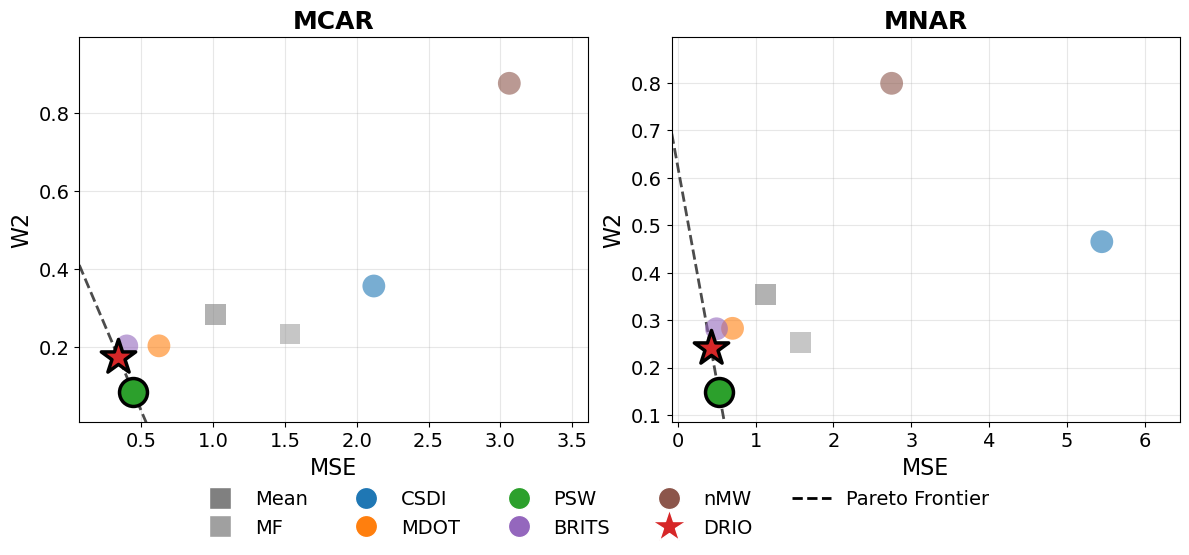


Pareto Frontier Summary (Averaged Across Datasets):
--------------------------------------------------
  MCAR: DRIO -> PSW
  MNAR: DRIO -> PSW


In [21]:
# Pareto Frontier Averaged Across Datasets
print("=" * 80)
print("PARETO FRONTIER (AVERAGED ACROSS DATASETS)")
print("=" * 80)

fig_avg = plot_pareto_averaged(df_mcar_mse, df_mcar_w2, df_mnar_mse, df_mnar_w2, 
                                save_path='results/pareto_averaged.pdf')

## CV Strategy Comparison Panel

Compare CV strategies using original error values:
- Ground Truth CV: results_cv/drio_brits (oracle)
- Reconstruction-based CV (Ours): results/drio_brits
- Prediction-based CV: results/drio_v2_brits

In [22]:
# Configuration for degradation analysis
RESULTS_CV_DIR = Path('results_cv')

# Datasets to use for degradation analysis (excluding har and physionet)
CV_DATASETS = ['cnnpred', 'pems08', 'pm25', 'gassensor', 'gait', 'pems04', 'cmapss', 'airquality']

# Methods to compare (including ground truth from results_cv)
CV_METHODS = ['drio_brits_cv', 'drio_brits', 'drio_v2_brits']
CV_METHOD_DISPLAY_NAMES = {
   'drio_brits_cv': 'Ground Truth Missingness CV (Not Deployable)',
    'drio_brits': 'Reconstruction-based CV (Ours)',
    'drio_v2_brits': 'Internal Masking Training + Reconstruction-based CV'
}
CV_METHOD_COLORS = {
    'drio_brits_cv': '#1A1A1A',   # dark gray/black for ground truth
    'drio_brits': '#A51C30',      # harvard red for ours
    'drio_v2_brits': '#6979b3'    # blue for internal masking
}
CV_METHOD_ALPHA = {
    'drio_brits_cv': 1.0,         # full opacity for ground truth
    'drio_brits': 1.0,            # full opacity for ours
    'drio_v2_brits': 0.6          # more transparent for internal masking
}


def load_results_from_dir(results_dir, dataset, missing_type, missing_ratio, method):
    """
    Load evaluation results from a specified results directory.
    
    Args:
        results_dir: Path to the results directory (results or results_cv)
        dataset: Dataset name
        missing_type: 'mcar' or 'mnar'
        missing_ratio: 10, 50, or 90
        method: Method name (e.g., 'drio_brits')
    
    Returns:
        dict with 'mse' and 'w2' from test split, or None if not found
    """
    folder_name = f"{dataset}_{missing_type}_{missing_ratio}pct_split70-10-20_seed42"
    json_path = results_dir / dataset / folder_name / method / 'evaluation_results.json'
    
    if not json_path.exists():
        return None
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        test_data = data.get('test', {})
        return {
            'mse': test_data.get('mse'),
            'w2': test_data.get('w2_global')
        }
    except Exception as e:
        print(f"Error loading {json_path}: {e}")
        return None


def get_metric_value(dataset, missing_type, missing_ratio, method, metric='mse'):
    """
    Get the original metric value for a given configuration.
    
    Args:
        dataset: Dataset name
        missing_type: 'mcar' or 'mnar'
        missing_ratio: 10, 50, or 90
        method: Method name ('drio_brits_cv', 'drio_brits', or 'drio_v2_brits')
        metric: 'mse' or 'w2'
    
    Returns:
        float: metric value, or np.nan if unavailable
    """
    # Determine which directory to load from
    if method == 'drio_brits_cv':
        results_dir = RESULTS_CV_DIR
        actual_method = 'drio_brits'
    else:
        results_dir = RESULTS_DIR
        actual_method = method
    
    result = load_results_from_dir(results_dir, dataset, missing_type, missing_ratio, actual_method)
    if result is None or result.get(metric) is None:
        return np.nan
    
    return result[metric]


def plot_degradation_panel(save_path=None):
    """
    Create 2x2 panel showing original error values.
    
    Row 1: MSE (Left: MCAR, Right: MNAR)
    Row 2: W2 (Left: MCAR, Right: MNAR)
    X-axis: missing ratio (10, 50, 90)
    Y-axis: Original error value (MSE or W2)
    Three lines per subplot: Ground Truth CV, Reconstruction-based CV, Prediction-based CV
    Error bars: 95% CI across datasets
    Shared legend at bottom
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    missing_types = ['mcar', 'mnar']
    metrics = ['mse', 'w2']
    metric_labels = {'mse': 'MSE', 'w2': 'W2'}
    missing_labels = {'mcar': 'MCAR', 'mnar': 'MNAR'}
    
    # Track missing data
    missing_data_report = []
    
    # Store handles for shared legend
    legend_handles = []
    legend_labels = []
    
    for row_idx, metric in enumerate(metrics):
        for col_idx, missing_type in enumerate(missing_types):
            ax = axes[row_idx, col_idx]
            
            for method in CV_METHODS:
                means = []
                ci_lower = []
                ci_upper = []
                
                for ratio in MISSING_RATIOS:
                    # Collect metric values across datasets
                    values = []
                    for dataset in CV_DATASETS:
                        val = get_metric_value(dataset, missing_type, ratio, method, metric)
                        if not np.isnan(val):
                            values.append(val)
                        else:
                            missing_data_report.append(f"{method}/{dataset}/{missing_type}_{ratio}%/{metric}")
                    
                    if len(values) > 0:
                        mean = np.mean(values)
                        std = np.std(values, ddof=1) if len(values) > 1 else 0
                        n = len(values)
                        # 95% CI
                        ci = 1.96 * std / np.sqrt(n) if n > 1 else 0
                        means.append(mean)
                        ci_lower.append(mean - ci)
                        ci_upper.append(mean + ci)
                    else:
                        means.append(np.nan)
                        ci_lower.append(np.nan)
                        ci_upper.append(np.nan)
                
                # Plot line with error bars
                color = CV_METHOD_COLORS[method]
                alpha = CV_METHOD_ALPHA[method]
                label = CV_METHOD_DISPLAY_NAMES[method]
                
                # Use dashed line for ground truth
                linestyle = '--' if method == 'drio_brits_cv' else '-'
                
                line = ax.errorbar(MISSING_RATIOS, means, 
                           yerr=[np.array(means) - np.array(ci_lower), 
                                 np.array(ci_upper) - np.array(means)],
                           marker='o', markersize=15, linewidth=5, capsize=10,
                           color=color, linestyle=linestyle, label=label, alpha=alpha)
                
                # Collect legend handles only from first subplot
                if row_idx == 0 and col_idx == 0:
                    legend_handles.append(line)
                    legend_labels.append(label)
            
            # Formatting
            ax.set_xlabel('Missing Ratio (%)', fontsize=14)
            ax.set_ylabel(f'{metric_labels[metric]}', fontsize=14)
            ax.set_xticks(MISSING_RATIOS)
            ax.set_xlim(5, 95)
            ax.tick_params(axis='both', labelsize=12)
            ax.grid(True, alpha=0.3)
            
            # Column title (only on top row)
            if row_idx == 0:
                ax.set_title(missing_labels[missing_type], fontsize=16, fontweight='bold', pad=10)
    
    # Shared legend at bottom
    fig.legend(legend_handles, legend_labels, loc='lower center', ncol=2, fontsize=12,
               bbox_to_anchor=(0.5, -0.02), frameon=False)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.10)  # Make room for legend
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()
    
    # Report missing data
    if missing_data_report:
        unique_missing = list(set(missing_data_report))
        print(f"\nMissing data combinations ({len(unique_missing)} total):")
        for item in sorted(unique_missing)[:20]:  # Show first 20
            print(f"  - {item}")
        if len(unique_missing) > 20:
            print(f"  ... and {len(unique_missing) - 20} more")
    else:
        print("\nNo missing data combinations.")
    
    return fig


CV COMPARISON PANEL (ORIGINAL ERROR VALUES)

Datasets used: ['cnnpred', 'pems08', 'pm25', 'gassensor', 'gait', 'pems04', 'cmapss', 'airquality']
Excluded: har, physionet
Methods compared:
  - Ground Truth CV: results_cv/drio_brits
  - Reconstruction-based CV (Ours): results/drio_brits
  - Prediction-based CV: results/drio_v2_brits
Saved figure to results/cv_comparison_panel.pdf


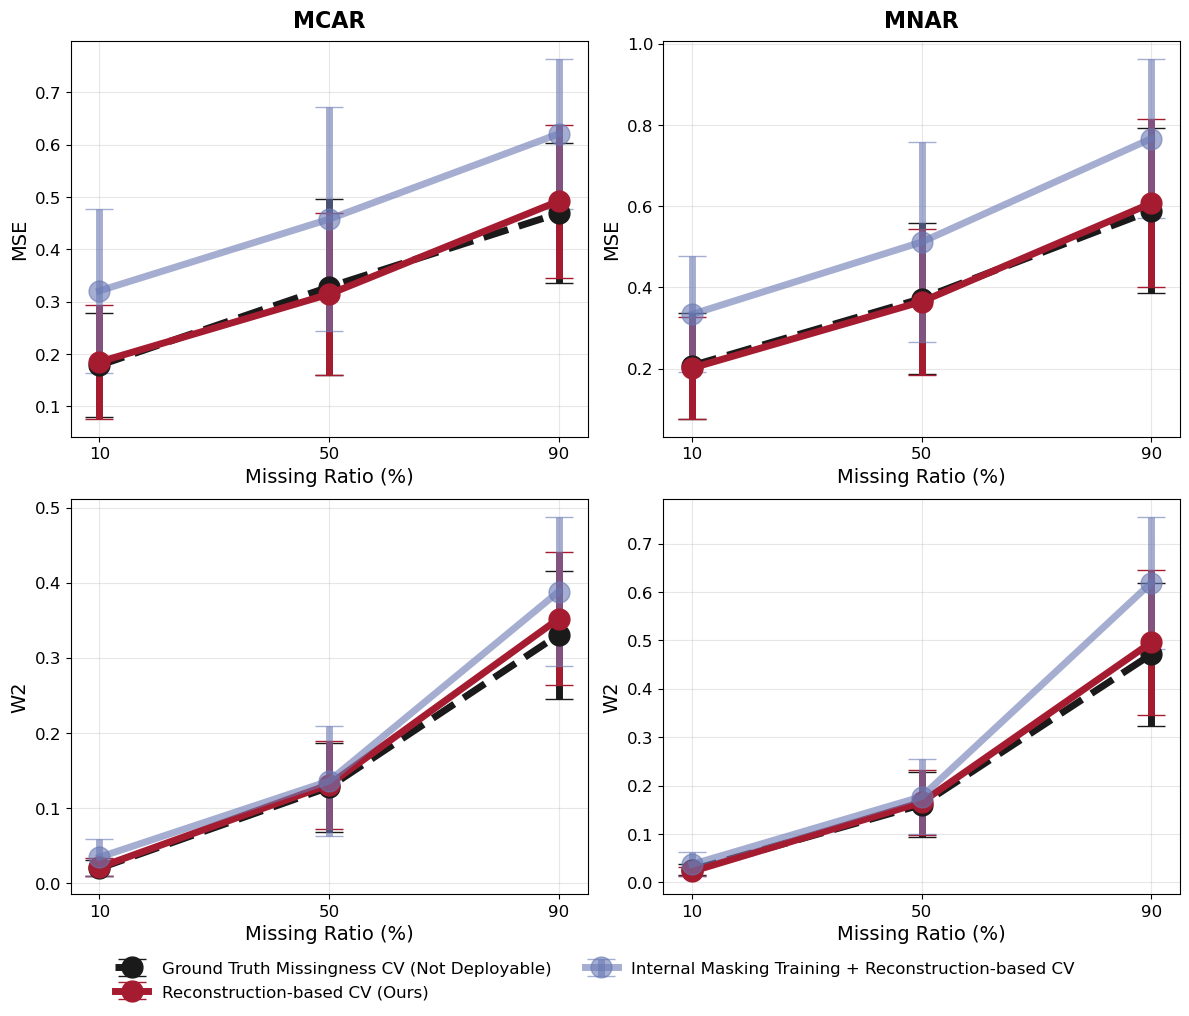


No missing data combinations.


In [23]:
# Generate and save degradation panel (original error values)
print("=" * 80)
print("CV COMPARISON PANEL (ORIGINAL ERROR VALUES)")
print("=" * 80)
print(f"\nDatasets used: {CV_DATASETS}")
print(f"Excluded: har, physionet")
print(f"Methods compared:")
print(f"  - Ground Truth CV: results_cv/drio_brits")
print(f"  - Reconstruction-based CV (Ours): results/drio_brits")
print(f"  - Prediction-based CV: results/drio_v2_brits")

fig_degradation = plot_degradation_panel(save_path='results/cv_comparison_panel.pdf')

## Ablation Study Tables

Compare different objectives and model backbones:
- **Objectives**: DRIO, BSH-DRIO, MSE
- **Backbones**: BRITS, MLP, LSTM, GAT, Transformer, STTransformer

4 Tables:
- MCAR MSE, MCAR W2, MNAR MSE, MNAR W2

In [24]:
# Ablation Study Configuration
# All 10 datasets
ABLATION_DATASETS = ['pems08','gait', 'cmapss', 'physionet']

# Define ablation rows: (objective_display, backbone_display, method_name)
ABLATION_ROWS = [
    # DRIO with different backbones
    ('DRIO', 'MLP', 'drio_mlp'),
    ('DRIO', 'LSTM', 'drio_lstm'),
    ('DRIO', 'GAT', 'drio_gat'),
    ('DRIO', 'STTransformer', 'drio_sttransformer'),
    ('DRIO', 'BRITS', 'drio_brits'),
    # BSH-DRIO
    ('BSH-DRIO', 'BRITS', 'bsh_drio_brits'),
    # MSE
    ('MSE', 'BRITS', 'mse_brits'),
    # Original BRITS (MSE + Consistency)
    ('MSE+Consist.', 'BRITS', 'brits'),
]


def compute_ablation_stats(method_name, missing_type, metric='mse'):
    """
    Compute mean and std across all datasets and missing ratios for a method.
    
    Returns (mean, std) or (np.nan, np.nan) if data unavailable.
    """
    values = []
    for dataset in ABLATION_DATASETS:
        for ratio in MISSING_RATIOS:
            result = load_results(dataset, missing_type, ratio, method_name)
            if result and result.get(metric) is not None:
                values.append(result[metric])
    
    if values:
        return np.mean(values), np.std(values, ddof=1)
    return np.nan, np.nan


def build_ablation_dataframe():
    """
    Build ablation study DataFrame with all metrics.
    
    Returns DataFrame with columns: Objective, Backbone, MCAR_MSE, MCAR_MSE_std, 
                                    MCAR_W2, MCAR_W2_std, MNAR_MSE, MNAR_MSE_std,
                                    MNAR_W2, MNAR_W2_std
    """
    data = []
    for objective, backbone, method_name in ABLATION_ROWS:
        row = {
            'Objective': objective,
            'Backbone': backbone,
        }
        for missing_type in ['mcar', 'mnar']:
            for metric in ['mse', 'w2']:
                mean, std = compute_ablation_stats(method_name, missing_type, metric)
                col_name = f"{missing_type.upper()}_{metric.upper()}"
                row[col_name] = mean
                row[f"{col_name}_std"] = std
        data.append(row)
    
    return pd.DataFrame(data)


def format_mean_std(mean, std):
    """Format as mean(std) with 2 decimal places."""
    if pd.isna(mean):
        return '--'
    if pd.isna(std):
        return f"{mean:.2f}"
    return f"{mean:.2f}({std:.2f})"


def generate_ablation_latex_table(df, caption, label):
    """
    Generate consolidated ablation LaTeX table.
    
    Two-row header: MCAR/MNAR on top, MSE/W2 below
    Rows grouped by objective
    Values as mean(std)
    """
    lines = []
    lines.append(r"\begin{table}[t]")
    lines.append(r"\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append(r"\footnotesize")
    
    # Column format: l l | c c | c c
    lines.append(r"\begin{tabular}{ll|cc|cc}")
    lines.append(r"\toprule")
    
    # Two-row header
    lines.append(r" & & \multicolumn{2}{c|}{MCAR} & \multicolumn{2}{c}{MNAR} \\")
    lines.append(r"\cmidrule(lr){3-4} \cmidrule(lr){5-6}")
    lines.append(r"Objective & Backbone & MSE & W2 & MSE & W2 \\")
    lines.append(r"\midrule")
    
    # Track current objective for grouping
    current_objective = None
    
    for idx, row in df.iterrows():
        objective = row['Objective']
        backbone = row['Backbone']
        
        # Add separator between objective groups
        if current_objective is not None and objective != current_objective:
            lines.append(r"\midrule")
        
        # For DRIO group, only show objective name on first row
        if objective == 'DRIO':
            if current_objective != 'DRIO':
                obj_display = 'DRIO'
            else:
                obj_display = ''
        elif objective == 'MSE+Consist.':
            # Special handling for Original BRITS - two-line display
            obj_display = r"\shortstack[l]{MSE+Consist.\\(Original BRITS)}"
        else:
            obj_display = objective
        
        # Format values
        mcar_mse = format_mean_std(row['MCAR_MSE'], row['MCAR_MSE_std'])
        mcar_w2 = format_mean_std(row['MCAR_W2'], row['MCAR_W2_std'])
        mnar_mse = format_mean_std(row['MNAR_MSE'], row['MNAR_MSE_std'])
        mnar_w2 = format_mean_std(row['MNAR_W2'], row['MNAR_W2_std'])
        
        lines.append(f"{obj_display} & {backbone} & {mcar_mse} & {mcar_w2} & {mnar_mse} & {mnar_w2} \\\\")
        
        current_objective = objective
    
    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")
    lines.append(r"\end{table}")
    
    return "\n".join(lines)

In [25]:
# Generate Ablation Study Table
print("=" * 80)
print("ABLATION STUDY TABLE")
print("=" * 80)
print(f"\nDatasets used: {ABLATION_DATASETS}")
print(f"Missing ratios: {MISSING_RATIOS}")
print(f"Total data points per cell: {len(ABLATION_DATASETS)} datasets × {len(MISSING_RATIOS)} ratios = {len(ABLATION_DATASETS) * len(MISSING_RATIOS)}")

# Build dataframe
df_ablation = build_ablation_dataframe()

# Display dataframe
print("\nAblation Study Results:")
print("-" * 80)
display_cols = ['Objective', 'Backbone', 'MCAR_MSE', 'MCAR_W2', 'MNAR_MSE', 'MNAR_W2']
print(df_ablation[display_cols].to_string(index=False))

# Generate LaTeX
latex_ablation = generate_ablation_latex_table(
    df_ablation,
    caption="Ablation study comparing training objectives and model backbones. Values show mean (std) across 10 datasets and 3 missing ratios (10\\%, 50\\%, 90\\%).",
    label="tab:ablation"
)

print("\n" + "=" * 80)
print("ABLATION LATEX TABLE")
print("=" * 80)
print(latex_ablation)

ABLATION STUDY TABLE

Datasets used: ['pems08', 'gait', 'cmapss', 'physionet']
Missing ratios: [10, 50, 90]
Total data points per cell: 4 datasets × 3 ratios = 12

Ablation Study Results:
--------------------------------------------------------------------------------
   Objective      Backbone  MCAR_MSE  MCAR_W2  MNAR_MSE  MNAR_W2
        DRIO           MLP  0.739438 0.223002  0.827654 0.272014
        DRIO          LSTM  0.662916 0.190421  0.738512 0.239313
        DRIO           GAT  1.611172 0.350885  1.604479 0.364572
        DRIO STTransformer  1.927810 0.413994  1.347685 0.316086
        DRIO         BRITS  0.330987 0.183172  0.435940 0.236357
    BSH-DRIO         BRITS  0.594445 0.311743  0.714634 0.354831
         MSE         BRITS  0.339443 0.189454  0.445244 0.246652
MSE+Consist.         BRITS  0.357551 0.203517  0.493702 0.272442

ABLATION LATEX TABLE
\begin{table}[t]
\centering
\caption{Ablation study comparing training objectives and model backbones. Values show mean (std

## Sensitivity Analysis: Alpha-Gamma Heatmaps

Create side-by-side heatmaps showing val_eval as a function of alpha (x-axis) and gamma (y-axis), averaged across all datasets and missing ratios. Left: MCAR, Right: MNAR.

In [26]:
# Sensitivity Analysis Configuration
SENSITIVITY_RESULTS_DIR = Path('results_cv')

# Datasets to include in sensitivity analysis
SENSITIVITY_DATASETS = ['cnnpred', 'pems08', 'pm25', 'gassensor', 'gait', 'pems04', 'cmapss', 'airquality', 'har', 'physionet']


def load_cv_results(dataset, missing_type, missing_ratio):
    """
    Load cv_results.json from results_cv directory.
    
    Returns dict with alpha_grid, gamma_grid, and results, or None if not found.
    """
    folder_name = f"{dataset}_{missing_type}_{missing_ratio}pct_split70-10-20_seed42"
    json_path = SENSITIVITY_RESULTS_DIR / dataset / folder_name / 'drio_brits' / 'cv_results.json'
    
    if not json_path.exists():
        return None
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error loading {json_path}: {e}")
        return None


def build_sensitivity_matrix(missing_type):
    """
    Build matrices of val_eval mean and std across datasets and missing ratios.
    
    Args:
        missing_type: 'mcar' or 'mnar'
    
    Returns:
        alpha_grid: list of alpha values
        gamma_grid: list of gamma values  
        mean_matrix: 2D numpy array of shape (len(gamma_grid), len(alpha_grid))
        std_matrix: 2D numpy array of shape (len(gamma_grid), len(alpha_grid))
    """
    # Get grids from first available file
    alpha_grid = None
    gamma_grid = None
    
    for dataset in SENSITIVITY_DATASETS:
        for ratio in MISSING_RATIOS:
            data = load_cv_results(dataset, missing_type, ratio)
            if data is not None:
                alpha_grid = data['alpha_grid']
                gamma_grid = data['gamma_grid']
                break
        if alpha_grid is not None:
            break
    
    if alpha_grid is None or gamma_grid is None:
        print(f"Could not find any cv_results for {missing_type}")
        return None, None, None, None
    
    # Initialize lists to collect all values for each (gamma, alpha) pair
    n_alpha = len(alpha_grid)
    n_gamma = len(gamma_grid)
    value_lists = [[[] for _ in range(n_alpha)] for _ in range(n_gamma)]
    
    # Collect values across all datasets and missing ratios
    for dataset in SENSITIVITY_DATASETS:
        for ratio in MISSING_RATIOS:
            data = load_cv_results(dataset, missing_type, ratio)
            if data is None:
                continue
            
            results = data['results']
            for i, gamma in enumerate(gamma_grid):
                for j, alpha in enumerate(alpha_grid):
                    key = f"({alpha}, {gamma})"
                    if key in results and 'val_eval' in results[key]:
                        val = results[key]['val_eval']
                        if val is not None and not np.isnan(val):
                            value_lists[i][j].append(val)
    
    # Compute mean and std
    mean_matrix = np.zeros((n_gamma, n_alpha))
    std_matrix = np.zeros((n_gamma, n_alpha))
    
    for i in range(n_gamma):
        for j in range(n_alpha):
            if len(value_lists[i][j]) > 0:
                mean_matrix[i, j] = np.mean(value_lists[i][j])
                std_matrix[i, j] = np.std(value_lists[i][j])
            else:
                mean_matrix[i, j] = np.nan
                std_matrix[i, j] = np.nan
    
    return alpha_grid, gamma_grid, mean_matrix, std_matrix


def plot_sensitivity_heatmaps(save_path=None):
    """
    Create side-by-side heatmaps for MCAR and MNAR sensitivity analysis.
    
    X-axis: alpha
    Y-axis: gamma
    Color: val_eval mean (averaged across datasets and missing ratios)
    Annotations: mean ± std
    Uses log-scale normalization to handle skewed data distribution.
    """
    from matplotlib.colors import LogNorm, Normalize
    from matplotlib.ticker import LogLocator, LogFormatterSciNotation
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    missing_types = ['mcar', 'mnar']
    titles = ['MCAR', 'MNAR']
    
    # Compute matrices for both
    matrices = {}
    for missing_type in missing_types:
        alpha_grid, gamma_grid, mean_matrix, std_matrix = build_sensitivity_matrix(missing_type)
        matrices[missing_type] = (alpha_grid, gamma_grid, mean_matrix, std_matrix)
    
    # Find global min/max for consistent colorbar (based on mean)
    all_values = []
    for missing_type in missing_types:
        _, _, mean_matrix, _ = matrices[missing_type]
        if mean_matrix is not None:
            all_values.extend(mean_matrix[~np.isnan(mean_matrix)].flatten())
    
    if not all_values:
        print("No data available for sensitivity analysis")
        return None
    
    all_values = np.array(all_values)
    vmin = max(all_values.min(), 0.01)  # Ensure positive for log scale
    vmax = all_values.max()
    
    # Use log normalization for better color distribution
    norm = LogNorm(vmin=vmin, vmax=vmax)
    
    # Use a perceptually uniform sequential colormap
    cmap = plt.cm.YlOrRd
    
    for ax_idx, (missing_type, title) in enumerate(zip(missing_types, titles)):
        ax = axes[ax_idx]
        alpha_grid, gamma_grid, mean_matrix, std_matrix = matrices[missing_type]
        
        if mean_matrix is None:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', fontsize=14)
            ax.set_title(title, fontsize=16, fontweight='bold')
            continue
        
        # Create heatmap with log-normalized colormap
        im = ax.imshow(mean_matrix, cmap=cmap, aspect='auto', 
                       norm=norm, origin='lower')
        
        # Set ticks
        ax.set_xticks(range(len(alpha_grid)))
        ax.set_xticklabels([f'{a}' for a in alpha_grid], fontsize=12)
        ax.set_yticks(range(len(gamma_grid)))
        ax.set_yticklabels([f'{g}' for g in gamma_grid], fontsize=12)
        
        # Labels
        ax.set_xlabel(r'$\alpha$', fontsize=16)
        ax.set_ylabel(r'$\gamma$', fontsize=16)
        ax.set_title(title, fontsize=16, fontweight='bold')
        
        # Add text annotations with mean ± std
        for i in range(len(gamma_grid)):
            for j in range(len(alpha_grid)):
                mean_val = mean_matrix[i, j]
                std_val = std_matrix[i, j]
                if not np.isnan(mean_val):
                    # Get normalized value to determine text color
                    norm_val = norm(mean_val)
                    text_color = 'white' if norm_val > 0.5 else 'black'
                    # Format as mean±std
                    annotation = f'{mean_val:.2f}\n({std_val:.2f})'
                    ax.text(j, i, annotation, ha='center', va='center', 
                           fontsize=14, color=text_color)
    
    # Add horizontal colorbar at bottom with log scale
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.22)
    cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.03])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('MSE of Ground Truth Missingness', fontsize=14)
    
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\nSensitivity Analysis Summary:")
    print("-" * 60)
    for missing_type, title in zip(missing_types, titles):
        alpha_grid, gamma_grid, mean_matrix, std_matrix = matrices[missing_type]
        if mean_matrix is not None:
            min_val = np.nanmin(mean_matrix)
            min_idx = np.unravel_index(np.nanargmin(mean_matrix), mean_matrix.shape)
            best_gamma = gamma_grid[min_idx[0]]
            best_alpha = alpha_grid[min_idx[1]]
            best_std = std_matrix[min_idx[0], min_idx[1]]
            print(f"  {title}: Best val_eval = {min_val:.4f} ± {best_std:.4f} at α={best_alpha}, γ={best_gamma}")
    
    return fig


SENSITIVITY ANALYSIS: ALPHA-GAMMA HEATMAPS

Datasets: ['cnnpred', 'pems08', 'pm25', 'gassensor', 'gait', 'pems04', 'cmapss', 'airquality', 'har', 'physionet']
Missing ratios: [10, 50, 90]
Data source: results_cv/
Saved figure to results/sensitivity_alpha_gamma.pdf


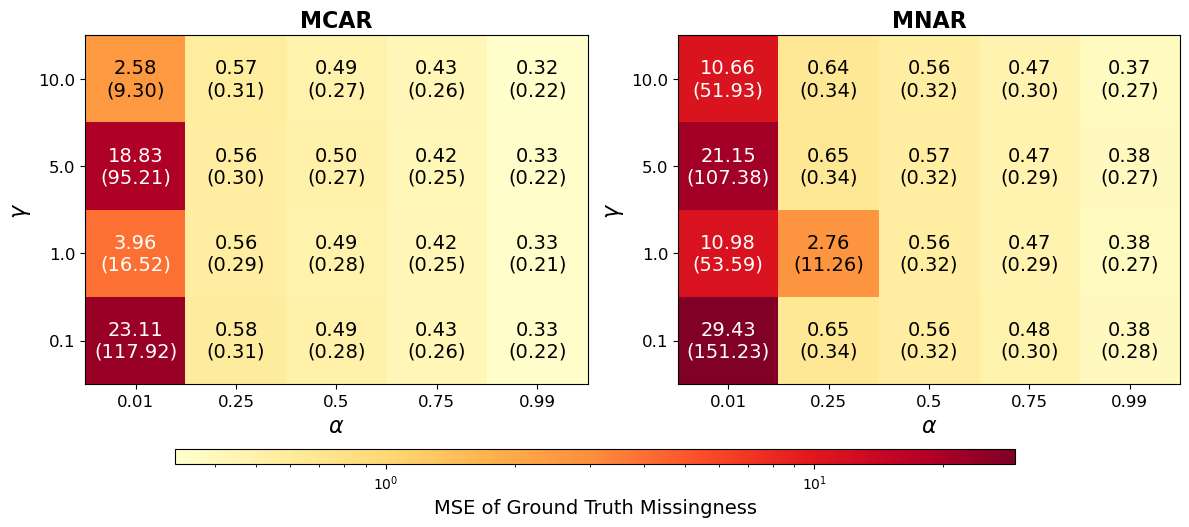


Sensitivity Analysis Summary:
------------------------------------------------------------
  MCAR: Best val_eval = 0.3227 ± 0.2154 at α=0.99, γ=10.0
  MNAR: Best val_eval = 0.3739 ± 0.2714 at α=0.99, γ=10.0


In [27]:
# Generate Sensitivity Analysis Heatmaps
print("=" * 80)
print("SENSITIVITY ANALYSIS: ALPHA-GAMMA HEATMAPS")
print("=" * 80)
print(f"\nDatasets: {SENSITIVITY_DATASETS}")
print(f"Missing ratios: {MISSING_RATIOS}")
print(f"Data source: results_cv/")

fig_sensitivity = plot_sensitivity_heatmaps(save_path='results/sensitivity_alpha_gamma.pdf')